### **1. Importación de librerías**

In [1]:
import tensorflow as tf
from pathlib import Path
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

Se importa las librerías necesarias:

* tensorflow: Principal librería usada para construir y entrenar la CNN.
* Path de pathlib: Sirve para manejar rutas de archivos y directorios de manera flexible.
* Sequential, Conv2D, y MaxPooling2D de tensorflow.keras.layers: Componentes específicos para construir una red CNN secuencial.

### **2. Obtención del directorio de trabajo actual y análisis exploratorio de datos**

In [2]:
current_directory = Path(os.getcwd())

Se obtiene el directorio de trabajo actual y lo guarda en current_directory. La función print imprime este directorio para confirmar que el script está corriendo en la ruta correcta, lo cual es útil para organizar rutas de archivos en sistemas operativos diferentes.

Cantidad de imágenes en el conjunto de entrenamiento:
{'angry': 3995, 'disgust': 436, 'fear': 4097, 'happy': 7215, 'neutral': 4965, 'sad': 4830, 'surprise': 3171}

Cantidad de imágenes en el conjunto de prueba:
{'angry': 958, 'disgust': 111, 'fear': 1024, 'happy': 1774, 'neutral': 1233, 'sad': 1247, 'surprise': 831}


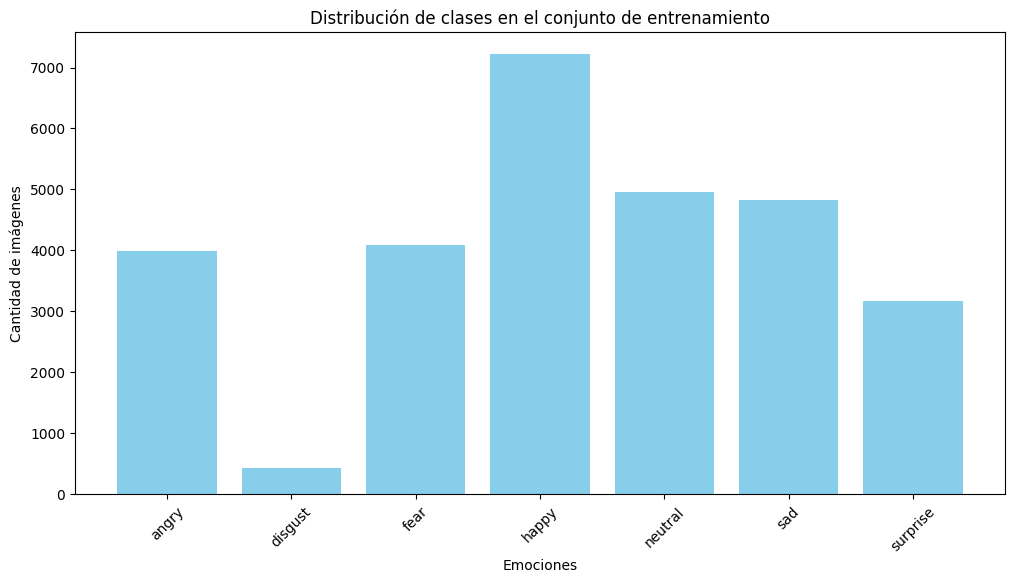

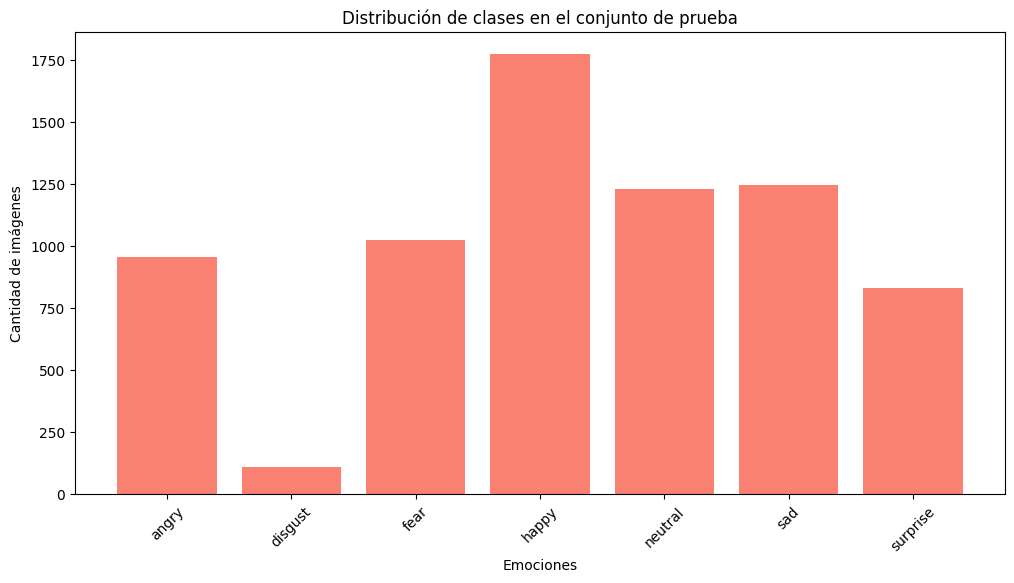

In [3]:
# Contar las imágenes en cada subdirectorio de train y test
train_dir = current_directory / 'data/train'
test_dir = current_directory / 'data/test'

def count_images_in_subdirs(directory):
    class_counts = {}
    for subdir in os.listdir(directory):
        subdir_path = directory / subdir
        if os.path.isdir(subdir_path):
            class_counts[subdir] = len(os.listdir(subdir_path))
    return class_counts

train_counts = count_images_in_subdirs(train_dir)
test_counts = count_images_in_subdirs(test_dir)

print("Cantidad de imágenes en el conjunto de entrenamiento:")
print(train_counts)
print("\nCantidad de imágenes en el conjunto de prueba:")
print(test_counts)

# Visualizar la distribución de clases en el conjunto de entrenamiento
plt.figure(figsize=(12, 6))
plt.bar(train_counts.keys(), train_counts.values(), color='skyblue')
plt.title('Distribución de clases en el conjunto de entrenamiento')
plt.xlabel('Emociones')
plt.ylabel('Cantidad de imágenes')
plt.xticks(rotation=45)
plt.show()

# Visualizar la distribución de clases en el conjunto de prueba
plt.figure(figsize=(12, 6))
plt.bar(test_counts.keys(), test_counts.values(), color='salmon')
plt.title('Distribución de clases en el conjunto de prueba')
plt.xlabel('Emociones')
plt.ylabel('Cantidad de imágenes')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Calcular el total de imágenes por categoría
train_counts = {emotion: len(os.listdir(f'{current_directory}/data/train/{emotion}')) for emotion in emotions}
test_counts = {emotion: len(os.listdir(f'{current_directory}/data/test/{emotion}')) for emotion in emotions}

# Calcular el porcentaje de imágenes por categoría respecto al total de cada categoría
percentages = {}
for emotion in emotions:
    total_images = train_counts[emotion] + test_counts.get(emotion, 0)
    train_percentage = (train_counts[emotion] / total_images) * 100 if total_images > 0 else 0
    test_percentage = (test_counts.get(emotion, 0) / total_images) * 100 if total_images > 0 else 0
    
    percentages[emotion] = {
        'total': f"{total_images} (100%)",
        'train': f"{train_counts[emotion]} ({train_percentage:.2f}%)",
        'test': f"{test_counts.get(emotion, 0)} ({test_percentage:.2f}%)"
    }

# Imprimir resultados
print("\nPorcentajes de imágenes por categoría:")
for emotion, data in percentages.items():
    print(f"{emotion.capitalize()}: Total {data['total']}, Train {data['train']}, Test {data['test']}")



Porcentajes de imágenes por categoría:
Angry: Total 4953 (100%), Train 3995 (80.66%), Test 958 (19.34%)
Disgust: Total 547 (100%), Train 436 (79.71%), Test 111 (20.29%)
Fear: Total 5121 (100%), Train 4097 (80.00%), Test 1024 (20.00%)
Happy: Total 8989 (100%), Train 7215 (80.26%), Test 1774 (19.74%)
Neutral: Total 6198 (100%), Train 4965 (80.11%), Test 1233 (19.89%)
Sad: Total 6077 (100%), Train 4830 (79.48%), Test 1247 (20.52%)
Surprise: Total 4002 (100%), Train 3171 (79.24%), Test 831 (20.76%)


### **3. Generador de datos de entrenamiento**

In [4]:
training_data_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
training_gen = training_data_gen.flow_from_directory(directory=f'{current_directory}/data/train', target_size=(48, 48), color_mode='grayscale', batch_size=32, class_mode='categorical')

Found 28709 images belonging to 7 classes.


Se crea un generador de datos para el conjunto de entrenamiento:

* ImageDataGenerator(rescale=1./255): Normaliza los valores de los píxeles de las imágenes entre 0 y 1 (originalmente están entre 0 y 255).
* flow_from_directory: Carga las imágenes desde el directorio /data/train, con las siguientes configuraciones:
    * target_size=(48, 48): Redimensiona las imágenes a 48x48 píxeles.
    * color_mode='grayscale': Carga las imágenes en escala de grises (1 canal).
    * batch_size=32: Genera los datos en lotes de 32 imágenes.
    * class_mode='categorical': Usa la clasificación categórica para múltiples categorías de emociones.

### **4. Generador de datos de prueba**

In [5]:
test_data_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_gen = test_data_gen.flow_from_directory(directory=f'{current_directory}/data/test', target_size=(48, 48), color_mode='grayscale', batch_size=32, class_mode='categorical')

Found 7178 images belonging to 7 classes.


Similar al anterior, pero se configura para el conjunto de prueba en /data/test. Permite evaluar el modelo en datos no vistos, garantizando que el modelo generaliza bien.

### **5. Definición del modelo**

In [6]:
model = tf.keras.Sequential()
emotions = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

Se crea una instancia Sequential, una arquitectura lineal de capas para la CNN. También se define una lista emotions que contiene las categorías de emociones (etiquetas de salida), utilizada más adelante para determinar el tamaño de la capa de salida.

### **6. Capas convolucionales y de agrupamiento**

In [7]:
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))

c:\Users\karlo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Se agrega capas de convolución y agrupamiento:

* Primera capa: Conv2D con 32 filtros y tamaño de kernel 3x3, relu como función de activación y input_shape=(48, 48, 1) (48x48 píxeles y 1 canal).
* Primera capa MaxPooling: Reduce la dimensión de la imagen a la mitad usando una ventana de 2x2.
* Segunda capa Conv2D: Conv2D con 64 filtros y un tamaño de kernel de 3x3, seguido de otra capa MaxPooling.
* Tercera capa Conv2D: Nueva capa Conv2D de 64 filtros.

Estas capas ayudan a extraer características de las imágenes, como bordes y texturas.

### **7. Aplanamiento de las salidas**

In [8]:
model.add(tf.keras.layers.Flatten())

Convierte la salida tridimensional de las capas convolucionales en una sola dimensión, preparándola para las capas densas que seguirán.

### **8. Capas densas para clasificación**

In [9]:
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(len(emotions), activation='softmax'))

Se agrega capas densas para la clasificación:

* La primera capa densa tiene 64 unidades y relu como función de activación.
* La segunda capa densa (capa de salida) tiene tantas unidades como categorías de emociones (len(emotions)), con activación softmax para producir una distribución de probabilidad para cada clase.

### **9. Compilación del modelo**

In [10]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Se compila el modelo con:

* optimizer='adam': Optimizador Adam para ajustar los pesos del modelo.
* loss='categorical_crossentropy': Pérdida adecuada para clasificación multiclase.
* metrics=['accuracy']: Métrica de precisión para monitorear el rendimiento.

### **10. Entrenamiento del modelo**

In [11]:
history = model.fit(training_gen, epochs=20, validation_data=test_gen)

Epoch 1/20


c:\Users\karlo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


898/898 ━━━━━━━━━━━━━━━━━━━━ 26s 27ms/step - accuracy: 0.3099 - loss: 1.7166 - val_accuracy: 0.4529 - val_loss: 1.4206
Epoch 2/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 17s 19ms/step - accuracy: 0.4639 - loss: 1.3910 - val_accuracy: 0.4937 - val_loss: 1.3029
Epoch 3/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 17s 19ms/step - accuracy: 0.5215 - loss: 1.2536 - val_accuracy: 0.5252 - val_loss: 1.2352
Epoch 4/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 18s 20ms/step - accuracy: 0.5619 - loss: 1.1461 - val_accuracy: 0.5375 - val_loss: 1.2172
Epoch 5/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 18s 20ms/step - accuracy: 0.5927 - loss: 1.0811 - val_accuracy: 0.5460 - val_loss: 1.2043
Epoch 6/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 18s 20ms/step - accuracy: 0.6319 - loss: 0.9934 - val_accuracy: 0.5449 - val_loss: 1.2057
Epoch 7/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 17s 19ms/step - accuracy: 0.6650 - loss: 0.9022 - val_accuracy: 0.5514 - val_loss: 1.2317
Epoch 8/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 17s 19ms/step - accuracy: 0.6981 - loss: 0.8272 - val_accurac

Este bloque entrena el modelo:

* training_gen: Datos de entrenamiento.
* epochs=20: Número de épocas para entrenar.
* validation_data=test_gen: Datos de validación para evaluar el modelo al final de cada época.

### **11. Guardado del modelo entrenado**

In [ ]:
model.save(f'{current_directory}/model/trained_model.h5')

Finalmente, el modelo entrenado se guarda en un archivo .h5 en el directorio /model/. Esto permite reutilizar el modelo sin necesidad de volver a entrenarlo.